92
subuser4

## Import

In [42]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import hstack

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, \
    cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedKFold, \
    cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, \
    median_absolute_error, mean_absolute_percentage_error, \
    mean_squared_error, get_scorer, accuracy_score

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from catboost import CatBoostRegressor, Pool
import catboost as cb

import xgboost as xgb
from xgboost import XGBRegressor

import optuna

from lightgbm import LGBMRegressor

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Data preprocessing

In [14]:
#get data from excel
df = pd.read_excel('Копия Расчёт регрессии_220322.xlsx',sheet_name = 10)

#remove nan values and reset indexes
df = df.drop(0)
df = df[df['H +1'].notna()]
df = df.reset_index(drop = True)

#labeling data 1 - increase, 0 - no change, -1 - descrease
labels = np.array(None)
for i in range(len(df)):
    if df.iloc[i]['H'] < df.iloc[i]['H +1']:
        labels = np.append(labels, 1.)
    elif df.iloc[i]['H'] == df.iloc[i]['H +1']:
        labels = np.append(labels, 0.)
    elif df.iloc[i]['H'] > df.iloc[i]['H +1']:
        labels = np.append(labels, -1.) 

#make features and target, df with both for analysis
X = df.loc[:, df.columns != 'H +1']
y = pd.Series(np.delete(labels,0),dtype=float,name = 'target')
df = pd.concat((df,y),axis =1)

In [15]:
df.dtypes

H -2         float64
H -1         float64
H            float64
Z_max -2     float64
Z_max -1     float64
Zmax         float64
H_zmax -2    float64
H_zmax -1    float64
H_zmax       float64
k1 -2        float64
k1 -1        float64
k1           float64
H +1         float64
target       float64
dtype: object

In [16]:
#description of data
df.describe()

,H -2,H -1,H,Z_max -2,Z_max -1,Zmax,H_zmax -2,H_zmax -1,H_zmax,k1 -2,k1 -1,k1,H +1,target
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,9995.436105,10171.906694,10265.720081,44.975659,46.346856,46.423935,3682.555781,3540.567951,3526.369168,3.237720,3.413663,3.448007,10277.383367,-0.081136
std,2152.082198,2056.305199,2020.570368,10.295206,9.040749,9.085904,1527.488626,1505.115695,1505.094466,1.665810,1.684579,1.669675,1989.941845,0.909251
min,4250.000000,4250.000000,4250.000000,2.000000,20.000000,18.000000,1000.000000,1000.000000,1000.000000,0.894737,1.052632,1.052632,4000.000000,-1.000000
25%,8500.000000,8750.000000,9000.000000,38.000000,40.000000,41.000000,2750.000000,2750.000000,2750.000000,2.052632,2.260870,2.315789,9000.000000,-1.000000
50%,10500.000000,10500.000000,10750.000000,47.000000,48.000000,48.000000,3750.000000,3750.000000,2750.000000,2.818182,3.000000,3.000000,10750.000000,0.000000
75%,11750.000000,11750.000000,11750.000000,53.000000,53.000000,54.000000,4750.000000,4750.000000,4750.000000,4.000000,4.181818,4.181818,11750.000000,1.000000
max,15000.000000,15000.000000,15000.000000,66.000000,66.000000,66.000000,9750.000000,9750.000000,9750.000000,11.500000,11.500000,11.500000,15000.000000,1.000000


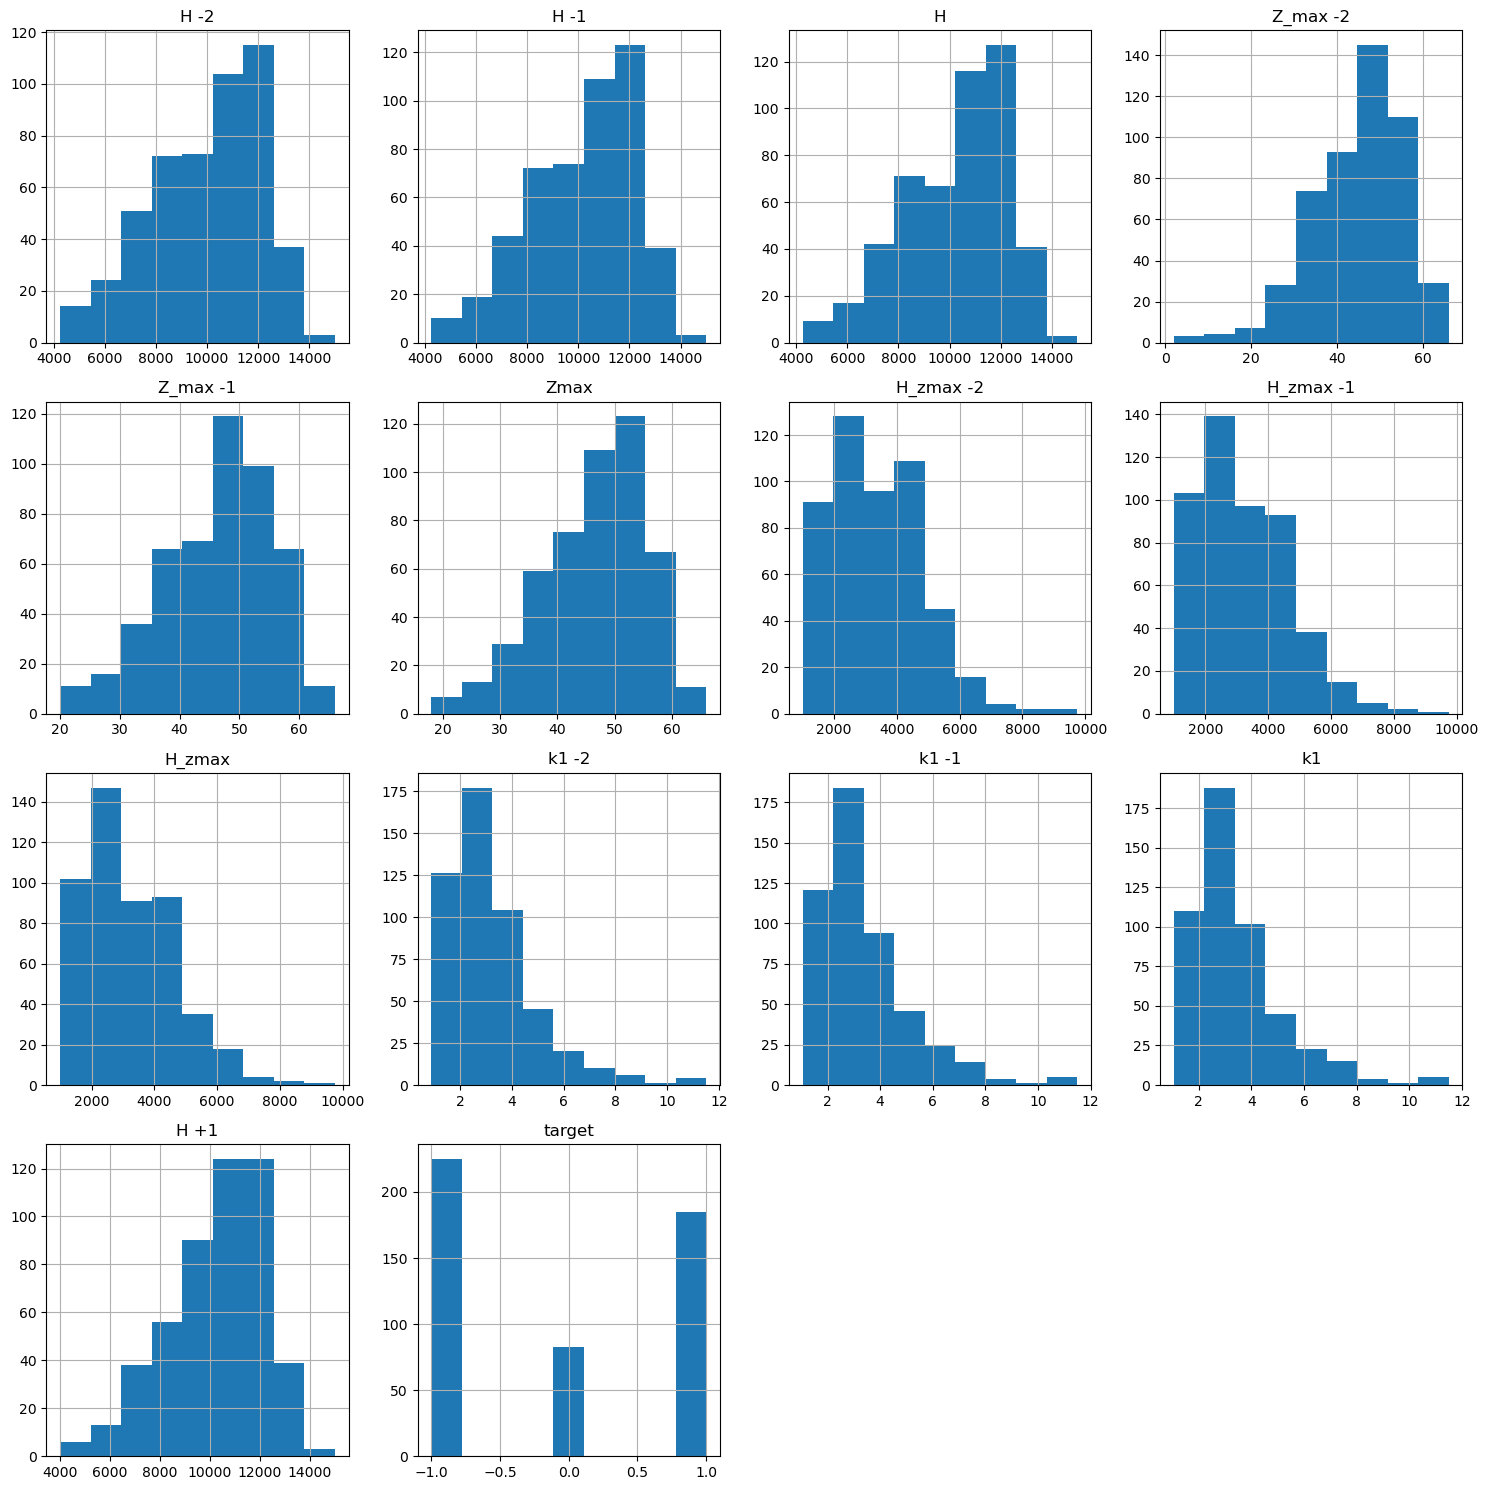

In [17]:
#plot histograms to understand data
df.hist(bins = 9,figsize=(15,15))
plt.tight_layout()

In [18]:
# Check the skew of all numerical features
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
k1 -2,1.743062
k1,1.736981
k1 -1,1.701613
H_zmax,0.734275
H_zmax -1,0.709516
H_zmax -2,0.613493
target,0.160422
Z_max -1,-0.462335
H -2,-0.481841
H -1,-0.524684


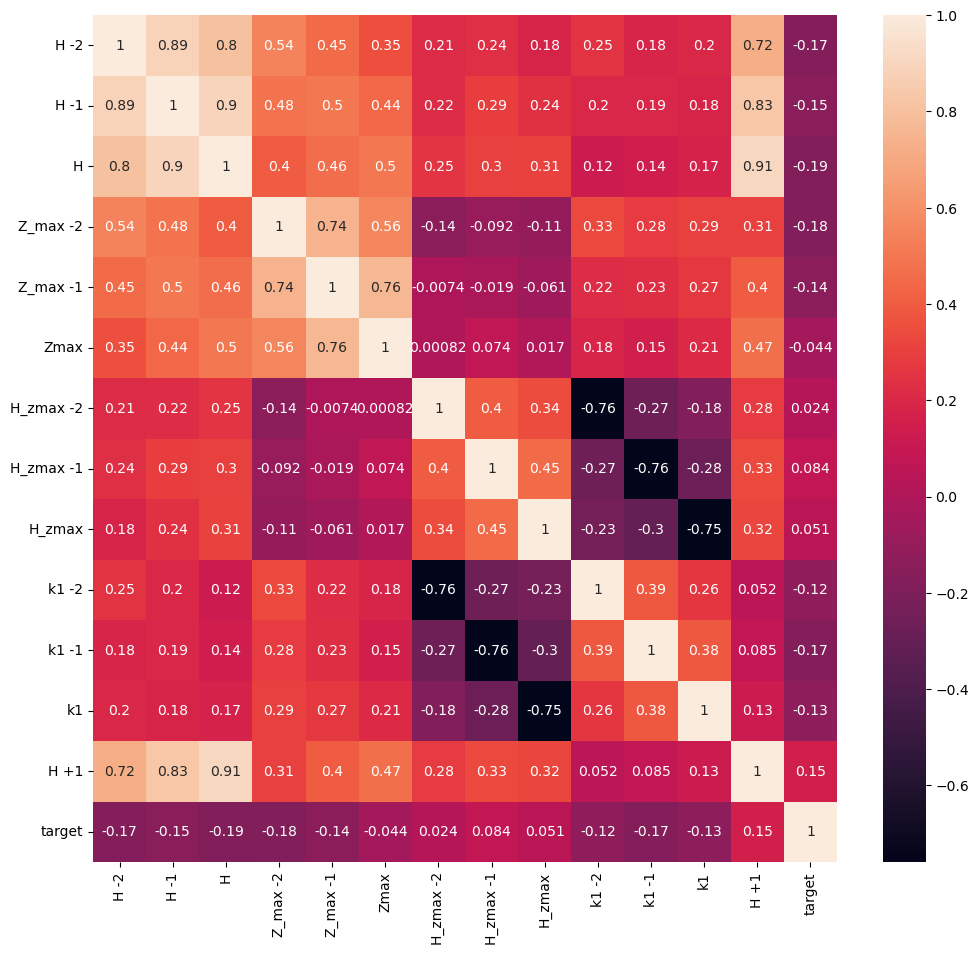

In [19]:
#visualisation of correlation 
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 11))
ax = sns.heatmap(corr, annot=True)

C:\Users\lazuli\AppData\Local\Temp\ipykernel_13708\2366867225.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y , fit = norm, bins = y.nunique());



 mu = -0.08 and sigma = 0.91



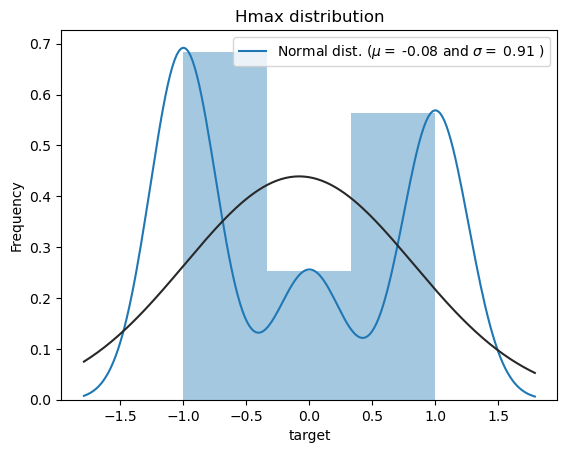

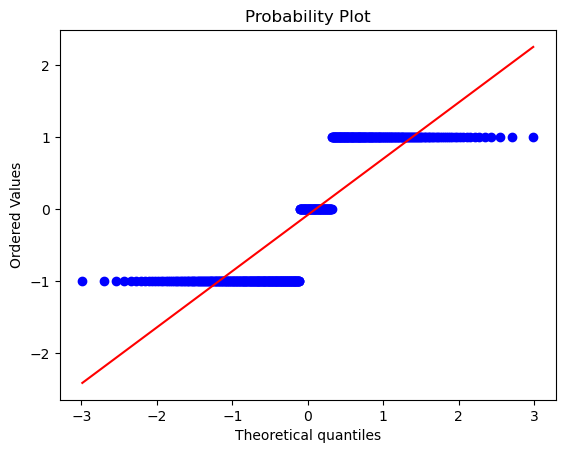

In [20]:
#analyze the target - Ht+1
sns.distplot(y , fit = norm, bins = y.nunique());

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Hmax distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

In [21]:
#train_test_sptit 0.2 size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train.shape

(394, 12)

In [10]:
#add poolynomial features
#poly = PolynomialFeatures(
#    degree = 2, include_bias = False, interaction_only = False)
#
#X_train_poly = poly.fit_transform(X_train)
#polynomial_column_names = \
#    poly.get_feature_names(input_features = X_train.columns)
#X_train_poly = \
#    pd.DataFrame(data = X_train_poly, 
#        columns = polynomial_column_names )
#
#X_train_poly.columns = X_train_poly.columns.str.replace(' ', '_')
#X_train_poly.columns = X_train_poly.columns.str.replace('^', '_')
#X_train_poly.shape

In [11]:
#X_test_poly = poly.fit_transform(X_test)
#polynomial_column_names = \
#    poly.get_feature_names(input_features = X_test.columns)
#X_test_poly = \
#    pd.DataFrame(data = X_test_poly, 
#        columns = polynomial_column_names)
#
#X_test_poly.columns = X_test_poly.columns.str.replace(' ', '_')
#X_test_poly.columns = X_test_poly.columns.str.replace('^', '_')
#X_test_poly.shape

In [25]:
#normalization of data
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
    return df_std
    
# call the z_score function
X_train_poly_scaled = z_score(X_train)#X_train_poly)

X_test_poly_scaled = z_score(X_test)#X_test_poly)

In [26]:
X_train_poly_scaled

,H -2,H -1,H,Z_max -2,Z_max -1,Zmax,H_zmax -2,H_zmax -1,H_zmax,k1 -2,k1 -1,k1
437,-1.061647,-1.307318,-1.829767,-1.819270,-1.772899,-1.719723,-0.623296,-1.169370,-1.149933,-0.238961,0.503868,0.157377
56,-1.295786,-1.795086,-2.074191,-0.030519,-0.864400,-1.389415,-1.261991,-1.169370,-0.497324,0.560843,0.166248,-0.770377
351,1.396810,1.741234,1.225531,0.665107,0.157661,-0.178288,1.292791,2.788239,0.155284,-0.575451,-0.980027,-0.032891
222,1.045602,1.009581,0.614472,1.062607,0.952598,0.702532,0.015400,-1.169370,-0.497324,0.031822,2.107564,0.440421
362,1.630949,1.253465,1.347743,-0.428019,-0.410150,1.253045,0.654096,0.149833,0.807893,-0.224517,-0.019443,-0.434366
...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.476300,-0.697608,-0.852072,-0.229269,0.157661,-1.059108,-0.623296,-0.509768,-0.497324,0.035482,-0.148353,-0.220014
270,-0.476300,-0.575666,-0.974283,0.565732,1.747535,1.473250,0.654096,0.809435,0.807893,-0.796513,-0.908806,-1.039766
348,1.630949,1.497349,1.225531,0.565732,0.271224,0.372225,1.292791,2.128638,1.460502,-0.522949,-0.868495,-0.748841
435,-0.476300,-0.697608,-1.218707,-0.726144,-1.772899,-2.160133,-1.261991,-0.509768,-0.497324,1.164617,-0.148353,-0.385123


In [27]:
X_train = X_train_poly_scaled
X_test = X_test_poly_scaled

In [28]:
#K-Fold Cross Validtion
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

## Models

## Logistic Regression with L1 - Regularization

In [31]:
from sklearn.linear_model import LogisticRegression
# instantiate the regressor class
LRL1 = LogisticRegression()

# fit the build the model by fitting the regressor to the training data
LRL1.fit(X_train, y_train)

# make a prediction set using the test set
prediction = LRL1.predict(X_test)

In [44]:
#Scores
scores = cross_val_score(LRL1, X_train, y_train, scoring='accuracy', cv=folds)
print(f"The accuracy on KFold cv:{np.round(np.mean(scores),3)}")  
print(f"The accuracy on test:{np.round(accuracy_score(y_test, prediction),3)}") 

The accuracy on KFold cv:0.493
The accuracy on test:0.515


Random forest

Optimization of forest parameters

In [51]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [54]:
#rf best params
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [55]:
# fit the build the model by fitting the regressor to the training data
RFB = rf_random.best_estimator_.fit(X_train,y_train)

# make a prediction set using the test set
prediction = RFB.predict(X_test)

In [56]:
#Scores
scores = cross_val_score(RFB, X_train, y_train, scoring='accuracy', cv=folds)
print(f"The accuracy on KFold cv:{np.round(np.mean(scores),3)}")  
print(f"The accuracy on test:{np.round(accuracy_score(y_test, prediction),3)}") 

The accuracy on KFold cv:0.478
The accuracy on test:0.576


CatBoost and tuning hyperparameters


In [57]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [58]:
#tuning using optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2022-09-14 16:58:10,199] A new study created in memory with name: no-name-c4f95925-fe56-45ca-b878-6f14baad7889
[W 2022-09-14 16:58:10,245] Trial 0 failed because of the following error: CatBoostError('C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/metrics/metric.cpp:6435: Min target less than 0: -1')
Traceback (most recent call last):
  File "C:\Users\lazuli\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\lazuli\AppData\Local\Temp\ipykernel_13708\1228609268.py", line 22, in objective
    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)
  File "C:\Users\lazuli\anaconda3\lib\site-packages\catboost\core.py", line 5007, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\lazuli\anaconda3\lib\site-packages\catboost\co

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/metrics/metric.cpp:6435: Min target less than 0: -1

In [36]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print(" Best Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 68
Best trial:
  Value: 558.9090909090909
 Best Params: 
    objective: RMSE
    colsample_bylevel: 0.06435137410140498
    depth: 9
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.8423867922978578


In [108]:
#define CB Regressor with best params
CBR = CatBoostRegressor(verbose = 0,colsample_bylevel= 0.0897439581179235,
    depth= 4, boosting_type= 'Plain',
    bootstrap_type= 'Bayesian',
    bagging_temperature= 2.5946134772473792).fit(X_train,y_train)
#get predictions of CBR
prediction = CBR.predict(X_test)

In [27]:
scores = cross_val_score(CBR, X, y, scoring='r2', cv=folds)
print(f"The R2 on KFold cv:{np.round(np.mean(scores),3)}")  
print(f"The R2 on test:{np.round(r2_score(y_test, prediction),3)}",'\n') 

scores = cross_val_score(CBR, X, y, scoring='neg_mean_absolute_error', cv=folds)
print(f"The MAE on KFold cv:{abs(np.round(np.mean(scores),3))}")  
print(f"The MAE on test:{np.round(mean_absolute_error(y_test, prediction),3)}",'\n')

scores = cross_val_score(CBR, X, y, scoring='neg_root_mean_squared_error', cv=folds)
print(f"The RMSE on KFold cv:{abs(np.round(np.mean(scores),3))}")  
print(f"The RMSE on test:{np.round(mean_squared_error(y_test, prediction, squared=False),3)}")

The R2 on KFold cv:0.807
The R2 on test:0.764 

The MAE on KFold cv:639.141
The MAE on test:657.704 

The RMSE on KFold cv:862.69
The RMSE on test:857.539


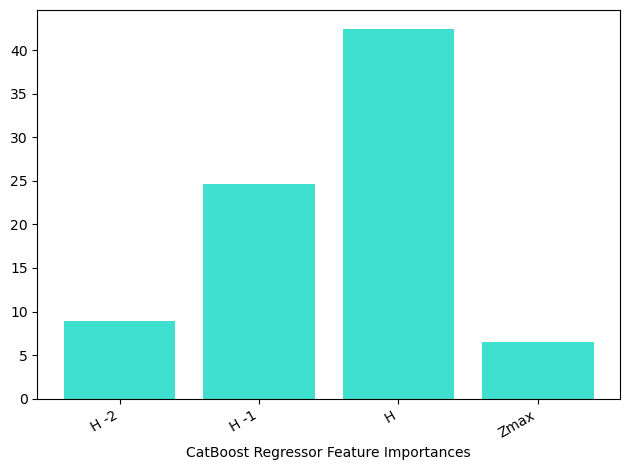

In [28]:
imp = pd.DataFrame(CBR.feature_importances_, index = list(X_train_poly_scaled.columns))
df3 = imp[imp[0] > 5]  
fig, ax = plt.subplots()
ax.bar(df3.index, 
        df3[0]
       ,color='turquoise')
plt.xlabel("CatBoost Regressor Feature Importances")
fig.autofmt_xdate()
plt.tight_layout()

In [32]:
pool = Pool(X, y, feature_names=list(X.columns))

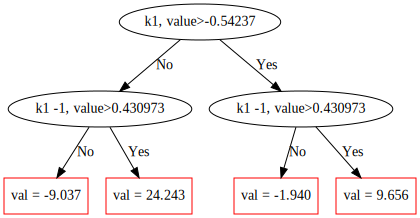

In [52]:
CBR.plot_tree(
    tree_idx=1,
    pool = pool)

## XGBRegressor hyperparameter tuning


In [78]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [109]:
XGBR = XGBRegressor(subsample=0.5, n_estimators= 500, max_depth= 5,
                                     learning_rate= 0.01, colsample_bytree= 0.7,
                                     min_child_weight =  5).fit(X_train,y_train)
#get predictions of CBR
prediction = XGBR.predict(X_test)

In [41]:
scores = cross_val_score(XGBR, X, y, scoring='r2', cv=folds)
print(f"The R2 on KFold cv:{np.round(np.mean(scores),3)}")  
print(f"The R2 on test:{np.round(r2_score(y_test, prediction),3)}",'\n') 

scores = cross_val_score(XGBR, X, y, scoring='neg_mean_absolute_error', cv=folds)
print(f"The MAE on KFold cv:{abs(np.round(np.mean(scores),3))}")  
print(f"The MAE on test:{np.round(mean_absolute_error(y_test, prediction),3)}",'\n')

scores = cross_val_score(XGBR, X, y, scoring='neg_root_mean_squared_error', cv=folds)
print(f"The RMSE on KFold cv:{abs(np.round(np.mean(scores),3))}")  
print(f"The RMSE on test:{np.round(mean_squared_error(y_test, prediction, squared=False),3)}")

The R2 on KFold cv:0.816
The R2 on test:0.752 

The MAE on KFold cv:622.85
The MAE on test:665.755 

The RMSE on KFold cv:840.694
The RMSE on test:879.133


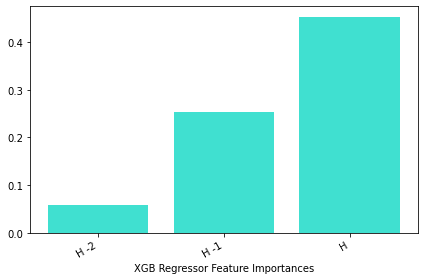

In [42]:
imp = pd.DataFrame(XGBR.feature_importances_, index = list(X_train_poly_scaled.columns))
df3 = imp[imp[0] > 0.05]  
fig, ax = plt.subplots()
ax.bar(df3.index, 
        df3[0]
       ,color='turquoise')
plt.xlabel("XGB Regressor Feature Importances")
fig.autofmt_xdate()
plt.tight_layout()

## LightGBM

In [92]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [97]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-09-12 11:26:05,428] A new study created in memory with name: no-name-00ccfd30-b360-47ab-afc6-d1b7efcedc23
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. 

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:08,530] Trial 24 finished with value: 867.1986126887842 and parameters: {'reg_alpha': 0.004361406743952621, 'reg_lambda': 0.23165794201335516, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 921, 'min_child_samples': 34}. Best is trial 22 with value: 822.9448991625829.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.s

[I 2022-09-12 11:26:09,438] Trial 29 finished with value: 1163.5975687428008 and parameters: {'reg_alpha': 0.001123446412266679, 'reg_lambda': 4.961013082947727, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 525, 'min_child_samples': 176}. Best is trial 22 with value: 822.9448991625829.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:12,546] Trial 54 finished with value: 859.0025002697989 and parameters: {'reg_alpha': 0.07494072987329585, 'reg_lambda': 6.863631106922242, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 756, 'min_child_samples': 54}. Best is trial 22 with value: 822.9448991625829.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

[I 2022-09-12 11:26:13,546] Trial 59 finished with value: 861.4991284499862 and parameters: {'reg_alpha': 0.013262079757856869, 'reg_lambda': 2.2182217553398553, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 423, 'min_child_samples': 40}. Best is trial 22 with value: 822.9448991625829.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:26:14,480] Trial 64 finished with value: 843.078928639578 and parameters: {'reg_alpha': 0.04977232182576245, 'reg_lambda': 7.470930182855861, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 961, 'min_child_samples': 25}. Best is trial 22 with value: 822.9448991625829.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugge

[I 2022-09-12 11:26:15,785] Trial 69 finished with value: 1164.8956341602975 and parameters: {'reg_alpha': 0.059295410510025966, 'reg_lambda': 0.014913964281194125, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 836, 'min_child_samples': 178}. Best is trial 22 with value: 822.9448991625829.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:19,508] Trial 94 finished with value: 816.9611451971282 and parameters: {'reg_alpha': 0.2661484386419488, 'reg_lambda': 0.162038641184858, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 768, 'min_child_samples': 5}. Best is trial 90 with value: 810.1395589714982.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest

[I 2022-09-12 11:26:20,965] Trial 99 finished with value: 808.4698444967474 and parameters: {'reg_alpha': 1.3865704524119662, 'reg_lambda': 0.05030717240912357, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 730, 'min_child_samples': 6}. Best is trial 99 with value: 808.4698444967474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugge

[I 2022-09-12 11:26:22,711] Trial 104 finished with value: 815.8779061376707 and parameters: {'reg_alpha': 0.34631963752530803, 'reg_lambda': 0.05124999027775337, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 790, 'min_child_samples': 5}. Best is trial 99 with value: 808.4698444967474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:26:24,147] Trial 109 finished with value: 855.6681380305562 and parameters: {'reg_alpha': 2.9255575557558267, 'reg_lambda': 0.10222460274078415, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 774, 'min_child_samples': 20}. Best is trial 99 with value: 808.4698444967474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:26:25,126] Trial 114 finished with value: 844.2435108066456 and parameters: {'reg_alpha': 1.247569927490687, 'reg_lambda': 0.03774420721233781, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 727, 'min_child_samples': 25}. Best is trial 99 with value: 808.4698444967474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:27,661] Trial 124 finished with value: 811.6312027814433 and parameters: {'reg_alpha': 0.35528250770523506, 'reg_lambda': 0.14774062545304914, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 783, 'min_child_samples': 7}. Best is trial 99 with value: 808.4698444967474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:26:28,149] Trial 129 finished with value: 854.8897874993501 and parameters: {'reg_alpha': 0.5945770506881979, 'reg_lambda': 0.018005141013239245, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 829, 'min_child_samples': 28}. Best is trial 99 with value: 808.4698444967474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

[I 2022-09-12 11:26:29,895] Trial 134 finished with value: 829.1015118839154 and parameters: {'reg_alpha': 0.26387016064821534, 'reg_lambda': 0.1547705359245219, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 696, 'min_child_samples': 1}. Best is trial 131 with value: 808.2264835891526.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:33,229] Trial 149 finished with value: 863.2640881363088 and parameters: {'reg_alpha': 0.8818670978845132, 'reg_lambda': 0.022484334675720957, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 712, 'min_child_samples': 35}. Best is trial 138 with value: 807.1018920261607.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.s

[I 2022-09-12 11:26:33,828] Trial 154 finished with value: 809.0513321115686 and parameters: {'reg_alpha': 3.936215382550989, 'reg_lambda': 0.03348013590759879, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 729, 'min_child_samples': 7}. Best is trial 138 with value: 807.1018920261607.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:36,095] Trial 164 finished with value: 815.2144570785136 and parameters: {'reg_alpha': 4.174388263942082, 'reg_lambda': 0.09585625108633893, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 856, 'min_child_samples': 8}. Best is trial 138 with value: 807.1018920261607.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

[I 2022-09-12 11:26:36,998] Trial 169 finished with value: 843.4967501272419 and parameters: {'reg_alpha': 2.808131641152269, 'reg_lambda': 0.2790827112584566, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 842, 'min_child_samples': 1}. Best is trial 138 with value: 807.1018920261607.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugge

[I 2022-09-12 11:26:37,787] Trial 174 finished with value: 821.6800640054985 and parameters: {'reg_alpha': 0.21161971875463614, 'reg_lambda': 0.003998044162254694, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 798, 'min_child_samples': 9}. Best is trial 138 with value: 807.1018920261607.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.s

[I 2022-09-12 11:26:38,448] Trial 179 finished with value: 807.3800080351416 and parameters: {'reg_alpha': 0.4597605607824175, 'reg_lambda': 0.002953622898590144, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 751, 'min_child_samples': 6}. Best is trial 138 with value: 807.1018920261607.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:44,021] Trial 199 finished with value: 810.4861237497321 and parameters: {'reg_alpha': 0.31164074313371626, 'reg_lambda': 0.0025191581646706956, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 766, 'min_child_samples': 7}. Best is trial 193 with value: 805.4677926538068.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.s

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:46,503] Trial 209 finished with value: 806.9611472147694 and parameters: {'reg_alpha': 1.3419703842373822, 'reg_lambda': 0.003434811854683303, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 761, 'min_child_samples': 6}. Best is trial 193 with value: 805.4677926538068.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:26:47,431] Trial 214 finished with value: 803.248248869474 and parameters: {'reg_alpha': 1.2890559227138925, 'reg_lambda': 0.003817476673470326, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 776, 'min_child_samples': 6}. Best is trial 214 with value: 803.248248869474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugge

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:26:50,735] Trial 224 finished with value: 807.0317668097363 and parameters: {'reg_alpha': 1.4745781005245076, 'reg_lambda': 0.003028861985281046, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 792, 'min_child_samples': 6}. Best is trial 214 with value: 803.248248869474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

[I 2022-09-12 11:26:52,681] Trial 229 finished with value: 822.4558402965789 and parameters: {'reg_alpha': 1.6348713481578638, 'reg_lambda': 0.006325823476164575, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 802, 'min_child_samples': 6}. Best is trial 214 with value: 803.248248869474.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:00,166] Trial 254 finished with value: 805.7334649666576 and parameters: {'reg_alpha': 1.191543038112623, 'reg_lambda': 0.002350151914259341, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 752, 'min_child_samples': 6}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

[I 2022-09-12 11:27:01,667] Trial 259 finished with value: 805.5174711643052 and parameters: {'reg_alpha': 1.4515334015847974, 'reg_lambda': 0.002307483396386658, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 748, 'min_child_samples': 6}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:03,821] Trial 269 finished with value: 822.989981382325 and parameters: {'reg_alpha': 1.1673026935299289, 'reg_lambda': 0.002980324291639084, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 753, 'min_child_samples': 10}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:09,091] Trial 284 finished with value: 807.6261933764433 and parameters: {'reg_alpha': 0.7000252626363066, 'reg_lambda': 0.002908492826972701, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 736, 'min_child_samples': 7}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:27:09,984] Trial 289 finished with value: 805.8300886602832 and parameters: {'reg_alpha': 0.7949029165323577, 'reg_lambda': 0.0012776103719414032, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 469, 'min_child_samples': 6}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

[I 2022-09-12 11:27:11,423] Trial 294 finished with value: 805.4517524118693 and parameters: {'reg_alpha': 1.0932321907018931, 'reg_lambda': 0.0013682391683733288, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 461, 'min_child_samples': 6}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:14,597] Trial 304 finished with value: 824.3124846475964 and parameters: {'reg_alpha': 1.4218308473775774, 'reg_lambda': 0.001254546852505458, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 409, 'min_child_samples': 1}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:16,687] Trial 314 finished with value: 838.4151699868391 and parameters: {'reg_alpha': 1.757996599968411, 'reg_lambda': 0.002241377330623955, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 451, 'min_child_samples': 16}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:27:18,081] Trial 319 finished with value: 806.2039290095357 and parameters: {'reg_alpha': 0.6333745614737984, 'reg_lambda': 0.0013396880553204421, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 591, 'min_child_samples': 6}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:21,787] Trial 334 finished with value: 806.2317308545271 and parameters: {'reg_alpha': 0.9434282932741901, 'reg_lambda': 0.0015751372685935117, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 502, 'min_child_samples': 6}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

[I 2022-09-12 11:27:23,354] Trial 339 finished with value: 826.3558949489067 and parameters: {'reg_alpha': 0.640737640420485, 'reg_lambda': 0.0017197749074777616, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 595, 'min_child_samples': 1}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:26,879] Trial 354 finished with value: 858.8274203405014 and parameters: {'reg_alpha': 0.6543233998948704, 'reg_lambda': 0.006182739586503864, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 609, 'min_child_samples': 34}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:29,731] Trial 364 finished with value: 823.0400577987768 and parameters: {'reg_alpha': 0.5173148401919213, 'reg_lambda': 0.0012103708947852029, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 462, 'min_child_samples': 10}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.s

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:34,914] Trial 379 finished with value: 806.8035631551155 and parameters: {'reg_alpha': 0.8248836517137721, 'reg_lambda': 0.0016215680593921551, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 575, 'min_child_samples': 6}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:38,421] Trial 394 finished with value: 1049.7527401251675 and parameters: {'reg_alpha': 0.5733590941713503, 'reg_lambda': 0.0021291932177418733, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 279, 'min_child_samples': 128}. Best is trial 242 with value: 803.1047062005248.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': tria

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:45,014] Trial 419 finished with value: 804.0431829655626 and parameters: {'reg_alpha': 1.2985719667632503, 'reg_lambda': 0.006029792843262921, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 541, 'min_child_samples': 6}. Best is trial 413 with value: 800.5367142288195.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

[I 2022-09-12 11:27:46,025] Trial 424 finished with value: 823.8492214015787 and parameters: {'reg_alpha': 2.464396569172788, 'reg_lambda': 0.004599985179273179, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 541, 'min_child_samples': 1}. Best is trial 413 with value: 800.5367142288195.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

[I 2022-09-12 11:27:47,030] Trial 429 finished with value: 824.6276454513106 and parameters: {'reg_alpha': 3.086281634361456, 'reg_lambda': 0.007651451105977605, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 526, 'min_child_samples': 1}. Best is trial 413 with value: 800.5367142288195.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:48,853] Trial 439 finished with value: 836.1622393963504 and parameters: {'reg_alpha': 2.289107302964784, 'reg_lambda': 0.012628817682654421, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 515, 'min_child_samples': 11}. Best is trial 413 with value: 800.5367142288195.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:51,838] Trial 454 finished with value: 805.6121294736345 and parameters: {'reg_alpha': 4.523366750594639, 'reg_lambda': 0.005444764190481591, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 689, 'min_child_samples': 7}. Best is trial 413 with value: 800.5367142288195.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

[I 2022-09-12 11:27:52,552] Trial 459 finished with value: 804.201185158066 and parameters: {'reg_alpha': 5.066980910125591, 'reg_lambda': 0.006049725777098317, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 686, 'min_child_samples': 6}. Best is trial 413 with value: 800.5367142288195.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugge

[I 2022-09-12 11:27:53,590] Trial 464 finished with value: 826.4019194863129 and parameters: {'reg_alpha': 3.8543515548421103, 'reg_lambda': 0.005569567485530571, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 678, 'min_child_samples': 11}. Best is trial 413 with value: 800.5367142288195.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.su

[I 2022-09-12 11:27:54,685] Trial 469 finished with value: 844.1197520599277 and parameters: {'reg_alpha': 5.562397885615101, 'reg_lambda': 0.004946174573920376, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 669, 'min_child_samples': 21}. Best is trial 465 with value: 798.8929289898367.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:57,017] Trial 479 finished with value: 857.0871602435572 and parameters: {'reg_alpha': 6.165573356631113, 'reg_lambda': 0.0076150871899162255, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 737, 'min_child_samples': 12}. Best is trial 465 with value: 798.8929289898367.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.s

C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\lazuli\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[I 2022-09-12 11:27:59,678] Trial 489 finished with value: 829.8847000314702 and parameters: {'reg_alpha': 5.735360634004572, 'reg_lambda': 0.004703783388654937, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 607, 'min_child_samples': 1}. Best is trial 465 with value: 798.8929289898367.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sugg

[I 2022-09-12 11:28:00,464] Trial 494 finished with value: 833.9011925591836 and parameters: {'reg_alpha': 2.208891681423836, 'reg_lambda': 0.0032469660857048356, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 734, 'min_child_samples': 6}. Best is trial 465 with value: 798.8929289898367.
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\lazuli\AppData\Local\Temp\ipykernel_1116\1066058584.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.sug

Number of finished trials: 500
Best trial: {'reg_alpha': 5.929464745575244, 'reg_lambda': 0.004401489485407623, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 674, 'min_child_samples': 6}


In [98]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print(" Best Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 500
Best trial:
  Value: 798.8929289898367
 Best Params: 
    reg_alpha: 5.929464745575244
    reg_lambda: 0.004401489485407623
    colsample_bytree: 0.6
    subsample: 0.8
    learning_rate: 0.02
    max_depth: 10
    num_leaves: 674
    min_child_samples: 6


In [99]:
params=study.best_params   

#define LGBM Regressor with best params
LGBMR = LGBMRegressor(**params).fit(X_train,y_train)

#get predictions of LGBM
prediction = LGBMR.predict(X_test)

In [100]:
scores = cross_val_score(LGBMR, X, y, scoring='r2', cv=folds)
print(f"The R2 on KFold cv:{np.round(np.mean(scores),3)}")  
print(f"The R2 on test:{np.round(r2_score(y_test, prediction),3)}",'\n') 

scores = cross_val_score(LGBMR, X, y, scoring='neg_mean_absolute_error', cv=folds)
print(f"The MAE on KFold cv:{abs(np.round(np.mean(scores),3))}")  
print(f"The MAE on test:{np.round(mean_absolute_error(y_test, prediction),3)}",'\n')

scores = cross_val_score(LGBMR, X, y, scoring='neg_root_mean_squared_error', cv=folds)
print(f"The RMSE on KFold cv:{abs(np.round(np.mean(scores),3))}")  
print(f"The RMSE on test:{np.round(mean_squared_error(y_test, prediction, squared=False),3)}")

The R2 on KFold cv:0.787
The R2 on test:0.791 

The MAE on KFold cv:686.82
The MAE on test:600.647 

The RMSE on KFold cv:910.867
The RMSE on test:805.935


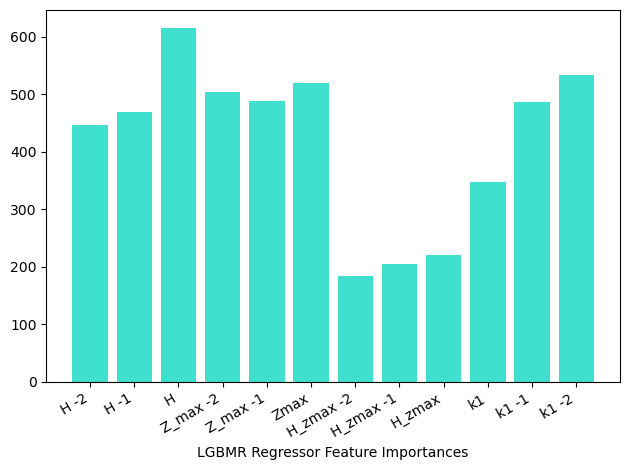

In [101]:
imp = pd.DataFrame(LGBMR.feature_importances_, index = list(X_train_poly_scaled.columns))
df3 = imp[imp[0] > 0.05]  
fig, ax = plt.subplots()
ax.bar(df3.index, 
        df3[0]
       ,color='turquoise')
plt.xlabel("LGBM Regressor Feature Importances")
fig.autofmt_xdate()
plt.tight_layout()

Stacking 

In [110]:
# compare ensemble to each standalone models for regression

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('LR L1', Lasso(alpha = 100)))
    #level0.append(('R F', rf_random.best_estimator_))
    level0.append(('C B', CBR))
    #level0.append(('XGB',XGBR))
    #level0.append(('LGBMR',LGBMR))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['LR L1'] = Lasso()
    #models['R F'] = rf_random.best_estimator_
    models['C B'] = CBR
    #models['XGB'] = XGBR
    #models['LGBMR'] = LGBMR
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y, scoring):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    return scores


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train,'neg_mean_absolute_error')
    r2_scores = evaluate_model(model, X_train, y_train,'r2')
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    print('>%s %.3f ' % (name, mean(r2_scores)))

>LR L1 -602.091 (97.154)
>LR L1 0.836 
>R F -643.010 (100.736)
>R F 0.810 
>C B -633.413 (99.188)
>C B 0.816 
>XGB -620.028 (103.122)
>XGB 0.823 
>LGBMR -690.583 (106.790)
>LGBMR 0.790 


KeyboardInterrupt: 

>LR L1 -602.091 (97.154)
>LR L1 0.836 
>R F -642.144 (101.896)
>R F 0.810 
>C B -633.413 (99.188)
>C B 0.816 
>XGB -620.028 (103.122)
>XGB 0.823 
>stacking -598.240 (94.507)
>stacking 0.835 

>LR L1 -602.091 (97.154)
>LR L1 0.836 
>XGB -620.028 (103.122)
>XGB 0.823 
>stacking -598.210 (96.492)
>stacking 0.835 

>LR L1 -602.091 (97.154)
>LR L1 0.836 
>C B -633.413 (99.188)
>C B 0.816 
>stacking -594.831 (93.374)
>stacking 0.835 

>LGBMR -690.583 (106.790)
>LGBMR 0.790 

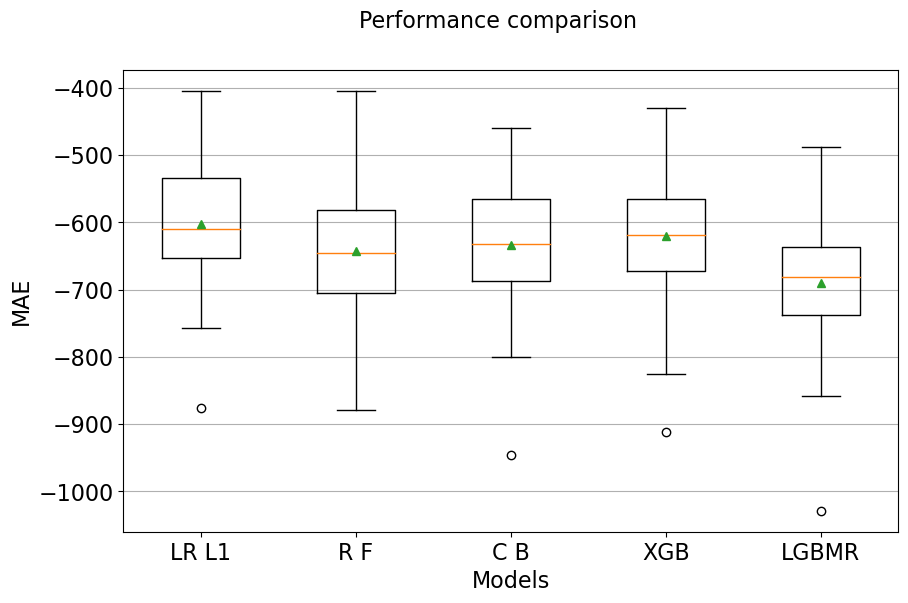

In [111]:
# plot model performance for comparison
fig, ax = plt.subplots(figsize=(10, 6))
plt.boxplot(results, labels = names, showmeans=True)
plt.grid(axis='y')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
    
plt.xlabel('Models', fontsize=16)
plt.ylabel('MAE', fontsize=16)

fig.suptitle('Performance comparison', fontsize = 16)
plt.show()

Text(0.5, 33.0, '')

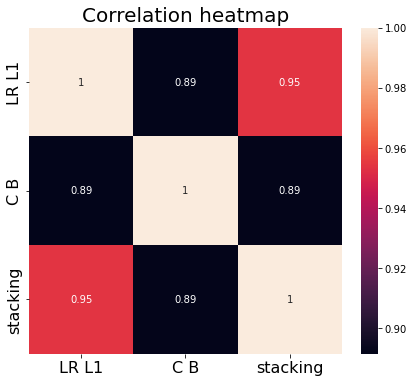

In [56]:
#make data more informational for visualization
corr = (pd.DataFrame(np.array(results)).T).corr()
corr = corr.set_axis([names], axis=1)
corr = corr.set_axis([names], axis=0)

#correlation of model's results
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
    
ax.set_title("Correlation heatmap", fontsize = 20)
ax.set_ylabel(None)
ax.set_xlabel(None)

In [57]:
model.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('LR L1', Lasso(alpha=100)),
                              ('C B',
                               <catboost.core.CatBoostRegressor object at 0x0000020FB9D4A430>)],
                  final_estimator=LinearRegression())

In [58]:
from sklearn.inspection import permutation_importance

scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
r_multi = permutation_importance(model, X_test_poly_scaled, y_test, n_repeats=30, random_state=0, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_test_poly_scaled.columns.values.tolist()[i]} "
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
H 1.122 +/- 0.153
Z_max -2 0.010 +/- 0.004
Z_max -1 0.005 +/- 0.002
neg_mean_absolute_error
H 994.727 +/- 107.443
Z_max -2 13.582 +/- 5.704
H_zmax 7.859 +/- 3.708
neg_root_mean_squared_error
H 1180.172 +/- 116.356
Z_max -2 16.985 +/- 6.460
Z_max -1 8.571 +/- 2.716
